In [1]:
import mujoco
import glfw
import numpy as np
import time
from gymnasium import Env, spaces

class ForceMatchingEnv(Env):
    def __init__(self, model_path, target_positions_path, max_distance=0.01):
        super(ForceMatchingEnv, self).__init__()

        self.model = mujoco.MjModel.from_xml_path(model_path)
        self.data = mujoco.MjData(self.model)

        # Definizione dello stato (x, y, vel_x, vel_y)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)

        # Azioni: (forza_x, forza_y)
        self.action_space = spaces.Box(low=-1000, high=1000, shape=(2,), dtype=np.float32)

        # Carica le posizioni target
        self.target_positions = np.load(target_positions_path)

        self.step_count = 0
        self.max_steps = 500
        self.max_distance = max_distance  # Distanza massima oltre la quale l'episodio termina

        # Inizializza GLFW per la visualizzazione
        if not glfw.init():
            raise Exception("Impossibile inizializzare GLFW")

        glfw.window_hint(glfw.VISIBLE, glfw.TRUE)
        self.window = glfw.create_window(800, 800, "MuJoCo Viewer", None, None)
        if not self.window:
            glfw.terminate()
            raise Exception("Errore nella creazione della finestra GLFW")

        glfw.make_context_current(self.window)

        # Configura la telecamera
        self.camera = mujoco.MjvCamera()
        self.camera.type = mujoco.mjtCamera.mjCAMERA_FREE
        self.camera.lookat = np.array([0, 0, 0])
        self.camera.distance = 2.0
        self.camera.azimuth = 90
        self.camera.elevation = -90

        # Renderer
        self.scene = mujoco.MjvScene(self.model, maxgeom=1000)
        self.context = mujoco.MjrContext(self.model, mujoco.mjtFontScale.mjFONTSCALE_150)

    def reset(self, seed=None, options=None):
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos[0] = self.target_positions[0][0]
        self.data.qpos[1] = self.target_positions[0][1]
        self.data.qvel[:] = 0
        mujoco.mj_forward(self.model, self.data)

        self.step_count = 0

        obs = np.array([self.data.qpos[0], self.data.qpos[1], self.data.qvel[0], self.data.qvel[1]])
        return obs, {}

    def step(self, action):
        action = np.array(action, dtype=np.float32)

        self.data.qfrc_applied[0] = action[0] * 500
        self.data.qfrc_applied[1] = action[1] * 500

        mujoco.mj_step(self.model, self.data)

        obs = np.array([self.data.qpos[0], self.data.qpos[1], self.data.qvel[0], self.data.qvel[1]])

        target_pos = self.target_positions[self.step_count]

        dist_x = np.abs(obs[0] - target_pos[0])
        dist_y = np.abs(obs[1] - target_pos[1])
        #distance = np.linalg.norm(obs[:2] - target_pos)

        flag = dist_x <= self.max_distance  and dist_y <= self.max_distance

        # Reward discreto
        reward = +1 if flag else 0

        # Termina episodio se troppo lontano
        done = (not flag) or self.step_count >= self.max_steps

        self.step_count += 1
        return obs, reward, done, False, {}

    def render(self):
        if glfw.window_should_close(self.window):
            glfw.destroy_window(self.window)
            glfw.terminate()
            return

        mujoco.mjv_updateScene(self.model, self.data, mujoco.MjvOption(), None, self.camera, mujoco.mjtCatBit.mjCAT_ALL, self.scene)
        viewport_width, viewport_height = glfw.get_framebuffer_size(self.window)
        viewport = mujoco.MjrRect(0, 0, viewport_width, viewport_height)
        mujoco.mjr_render(viewport, self.scene, self.context)

        glfw.swap_buffers(self.window)
        glfw.poll_events()

    def close(self):
        glfw.destroy_window(self.window)
        glfw.terminate()


Episode 0, Total Reward: 7
Episode 10, Total Reward: 16
Episode 20, Total Reward: 10
Episode 30, Total Reward: 11
Episode 40, Total Reward: 9
Episode 50, Total Reward: 9
Episode 60, Total Reward: 11


/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_18404/2830174399.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 70, Total Reward: 10
Episode 80, Total Reward: 11
Episode 90, Total Reward: 12
Episode 100, Total Reward: 8
Episode 110, Total Reward: 9
Episode 120, Total Reward: 13
Episode 130, Total Reward: 14
Episode 140, Total Reward: 9
Episode 150, Total Reward: 12
Episode 160, Total Reward: 16
Episode 170, Total Reward: 12
Episode 180, Total Reward: 12
Episode 190, Total Reward: 10
Episode 200, Total Reward: 11
Episode 210, Total Reward: 11
Episode 220, Total Reward: 17
Episode 230, Total Reward: 11
Episode 240, Total Reward: 14
Episode 250, Total Reward: 11
Episode 260, Total Reward: 14
Episode 270, Total Reward: 11
Episode 280, Total Reward: 11
Episode 290, Total Reward: 12
Episode 300, Total Reward: 16
Episode 310, Total Reward: 14
Episode 320, Total Reward: 15
Episode 330, Total Reward: 11
Episode 340, Total Reward: 25
Episode 350, Total Reward: 20
Episode 360, Total Reward: 14
Episode 370, Total Reward: 13
Episode 380, Total Reward: 24
Episode 390, Total Reward: 19
Episode 400, Tot

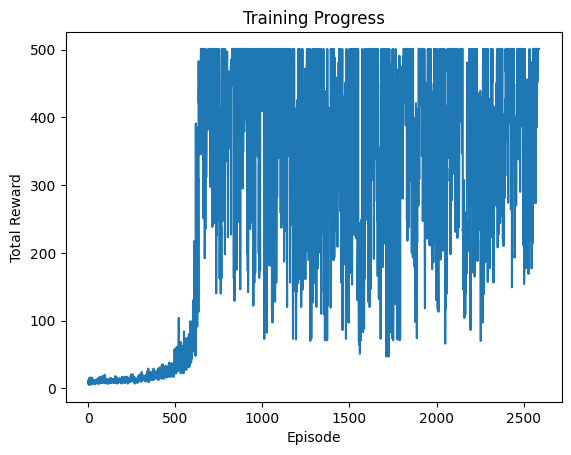

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

MAX_MEMORY = 700
NUM_NEURONS = 64
LR_CRITIC = 0.0005
LR_ACTOR = 0.001
GAMMA = 0.99
LAMBDA = 0.95
CLIP_EPS = 0.2
K_EPOCH = 10
EARLY_STOP_THRESHOLD = 475
EPISODES_EARLY_STOP = 30
MAX_EPISODES = 20000

def compute_advantages(rewards, values, dones, gamma=GAMMA, lam=LAMBDA):
    advantages = []
    gae = 0
    values = values + [0]  # Append a 0 for the last state
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    return torch.tensor(advantages, dtype=torch.float32)

def compute_returns(rewards, dones, gamma=0.99):
    returns = []
    G = 0
    for reward, done in zip(reversed(rewards), reversed(dones)):
        G = reward + gamma * G * (1 - done)  # Reset if episode ended
        returns.insert(0, G)
    return torch.tensor(returns, dtype=torch.float32)

class PolicyNet(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PolicyNet, self).__init__()
        
        self.dense=nn.Sequential(
            nn.Linear(num_inputs, NUM_NEURONS),
            nn.ReLU(),
            nn.Linear(NUM_NEURONS, NUM_NEURONS),
            nn.ReLU(),
        )

        # Output della media delle azioni
        self.mean_layer = nn.Linear(NUM_NEURONS, num_actions)
        
        # Output della deviazione standard (log std per stabilità numerica)
        self.log_std_layer = nn.Linear(NUM_NEURONS, num_actions)

    def forward(self, x):
        x = self.dense(x)
        mean = self.mean_layer(x)
        
        # Il log_std viene trasformato in std con exp() per garantire valori positivi
        log_std = self.log_std_layer(x)
        std = torch.exp(log_std)
        
        return mean, std

class ValueNet(nn.Module):
    def __init__(self, num_inputs):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class PPOAgent(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PPOAgent, self).__init__()
        self.actor = PolicyNet(num_inputs, num_actions)
        self.critic = ValueNet(num_inputs)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.buffer = []
    
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        mu, sigma = self.actor(state)
        dist = Normal(mu, sigma)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()
        return action.detach().numpy(), log_prob

    def store_transition(self, transition):
        self.buffer.append(transition)
    
    def update(self):
        states, actions, rewards, dones, old_log_probs = zip(*self.buffer)
        old_log_probs = torch.stack(old_log_probs)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)  # Azioni continue
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        values = self.critic(states).squeeze()
        advantages = compute_advantages(rewards.tolist(), values.tolist(), dones.tolist())
        returns = compute_returns(rewards.tolist(), dones.tolist())

        for _ in range(K_EPOCH):
            mu, sigma = self.actor(states)
            new_dist = Normal(mu, sigma)
            new_log_probs = new_dist.log_prob(actions).sum(dim=1)

            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            #entropy_loss = -0.01 * new_dist.entropy().mean()  # Il valore 0.01 regola l'importanza dell'esplorazione
            #policy_loss += entropy_loss
            value_loss = F.mse_loss(self.critic(states).squeeze(), returns)

            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            policy_loss.backward()
            value_loss.backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()

        self.buffer.clear()

def train_ppo(num_episodes=MAX_EPISODES):
    env = ForceMatchingEnv("/Users/edoardozappia/Desktop/Tesi_Magistrale/irregular_shape_2D.xml", "/Users/edoardozappia/Desktop/Tesi_Magistrale/target_positions.npy")
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]  # Ora è continuo
    agent = PPOAgent(num_inputs, num_actions)
    reward_history = []
    
    for episode in range(num_episodes):
        #print(f"Episode: {episode}")
        state, _ = env.reset()
        #print(state.shape)
        done = False
        early_stop = False
        total_reward = 0
        
        while not done:
            action, log_prob = agent.get_action(state)
            #print(state.shape)
            next_state, reward, terminated, truncated, _ = env.step(action)
            #print(f"Reward: {reward}")
            done = terminated or truncated
            #print(f"done: {done}")
            agent.store_transition((state, action, reward, done, log_prob))
            state = next_state
            total_reward += reward

        reward_history.append(total_reward)

        if len(reward_history) >= 50 and np.mean(reward_history[-EPISODES_EARLY_STOP:]) > EARLY_STOP_THRESHOLD:
            print(f"Early stopping at episode {episode}, average reward: {np.mean(reward_history[-30:])}")
            early_stop = True
            break
        
        if early_stop:
            break

        if len(agent.buffer) >= MAX_MEMORY:
            agent.update()
        
        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")
    
    env.close()

    plt.plot(reward_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()

    return agent

if __name__ == "__main__":
    trained_agent = train_ppo()


▶️ Test della policy appresa...
Posizione: x=0.001, y=0.001 | Posizione target: x=0.001, y=0.001 Azione: [1.2237368 1.2660549] | Reward: 1.000
Posizione: x=0.002, y=0.002 | Posizione target: x=0.002, y=0.002 Azione: [1.0154549 1.0719773] | Reward: 1.000
Posizione: x=0.003, y=0.003 | Posizione target: x=0.003, y=0.003 Azione: [1.1593014 0.9227936] | Reward: 1.000
Posizione: x=0.004, y=0.004 | Posizione target: x=0.004, y=0.004 Azione: [1.1173238 0.8736349] | Reward: 1.000
Posizione: x=0.005, y=0.005 | Posizione target: x=0.004, y=0.004 Azione: [1.0191951 1.0041536] | Reward: 1.000
Posizione: x=0.006, y=0.006 | Posizione target: x=0.005, y=0.005 Azione: [1.2161919 0.972345 ] | Reward: 1.000
Posizione: x=0.008, y=0.007 | Posizione target: x=0.006, y=0.006 Azione: [1.3847946 1.0313993] | Reward: 1.000
Posizione: x=0.008, y=0.007 | Posizione target: x=0.007, y=0.007 Azione: [0.773208   0.98694193] | Reward: 1.000
Posizione: x=0.009, y=0.008 | Posizione target: x=0.008, y=0.008 Azione: [1.06

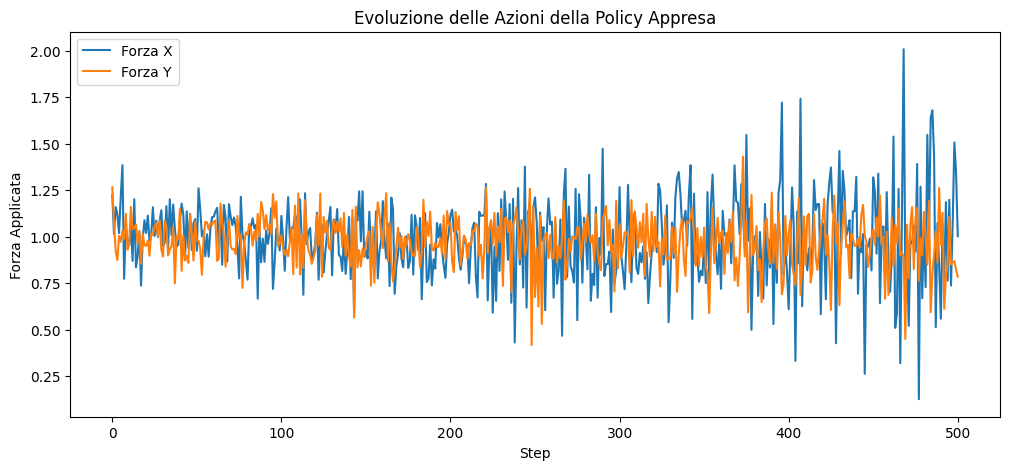

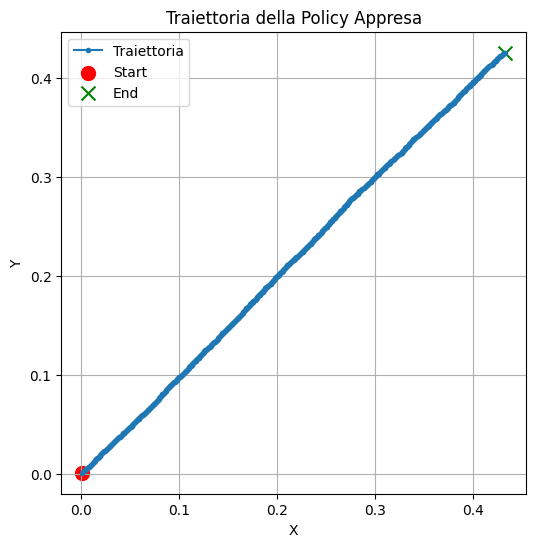

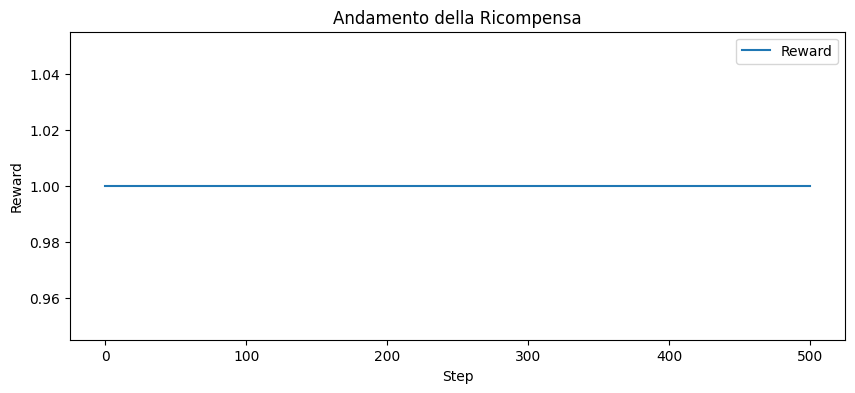

: 

In [ ]:
import numpy as np
import torch
import mujoco
import time
import matplotlib.pyplot as plt

# Inizializza l'ambiente
env = ForceMatchingEnv("/Users/edoardozappia/Desktop/Tesi_Magistrale/irregular_shape_2D.xml", "/Users/edoardozappia/Desktop/Tesi_Magistrale/target_positions.npy")
target_positions = np.load("/Users/edoardozappia/Desktop/Tesi_Magistrale/target_positions.npy")
# Assumi che il modello PPO sia già stato allenato e in memoria
agent = trained_agent
agent.eval()  # Metti il modello in modalità valutazione

# Reset dell'ambiente
state, _ = env.reset()
done = False

# Liste per il logging
episode_rewards = []
positions = []
actions_list = []

print("▶️ Test della policy appresa...")
i = 1

while not done:
    # Ottieni l'azione dalla policy senza esplorazione
    with torch.no_grad():
        action, _ = agent.get_action(state)

    # Esegui l'azione nell'ambiente
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    # Salva i dati
    episode_rewards.append(reward)
    positions.append((env.data.qpos[0], env.data.qpos[1]))
    actions_list.append(action)

    # Stampa informazioni
    print(f"Posizione: x={env.data.qpos[0]:.3f}, y={env.data.qpos[1]:.3f} | Posizione target: x={target_positions[i][0]:.3f}, y={target_positions[i][1]:.3f} Azione: {action} | Reward: {reward:.3f}")

    i += 1

    # Aggiorna lo stato
    state = next_state

    # Visualizza l'ambiente (solo se sei su una macchina con GUI)
    env.render()
    time.sleep(0.05)  # Piccola pausa per visualizzazione fluida

env.close()

# ▶️ **Plotta le azioni nel tempo**
actions_list = np.array(actions_list)
plt.figure(figsize=(12, 5))
plt.plot(actions_list[:, 0], label="Forza X")
plt.plot(actions_list[:, 1], label="Forza Y")
plt.xlabel("Step")
plt.ylabel("Forza Applicata")
plt.title("Evoluzione delle Azioni della Policy Appresa")
plt.legend()
plt.show()

# ▶️ **Plotta la traiettoria seguita**
positions = np.array(positions)
plt.figure(figsize=(6, 6))
plt.plot(positions[:, 0], positions[:, 1], marker="o", linestyle="-", markersize=3, label="Traiettoria")
plt.scatter([positions[0, 0]], [positions[0, 1]], color="red", label="Start", marker="o", s=100)
plt.scatter([positions[-1, 0]], [positions[-1, 1]], color="green", label="End", marker="x", s=100)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Traiettoria della Policy Appresa")
plt.legend()
plt.grid()
plt.show()

# ▶️ **Plotta l'andamento della ricompensa**
plt.figure(figsize=(10, 4))
plt.plot(episode_rewards, label="Reward")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Andamento della Ricompensa")
plt.legend()
plt.show()
